In [345]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from talib import RSI, BBANDS, MACD
import yfinance as yf
from dateutil import tz
from datetime import date, datetime
from matplotlib.ticker import PercentFormatter, FuncFormatter

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 3.5)
sns.set_style('whitegrid')

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [346]:
def human_format_dollar_or_num(dollar=False, decimals=0):
    """ 
    Return a function for formatting matplot axis numbers human friendly. 

    Parameters
    ----------
    dollar: logical
        If True, will add $ in front of the numbers.
    decimals: int
        Number of decimals to display.
    """

    base_fmt = '%.{}f%s'.format(decimals)
    if dollar:
        base_fmt = '$' + base_fmt

    def human_format(num, pos): # pos is necessary as it'll be used by matplotlib
        magnitude = 0
        while abs(num) >= 1000:
            magnitude += 1
            num /= 1000.0
        return base_fmt % (num, ['', 'K', 'M', 'B', 'T', 'P'][magnitude])
    return human_format

dollar_formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))

In [347]:
# set paths and create dirs 
base_dir = '../'
png_dir = os.path.join(base_dir, 'png')
os.makedirs(png_dir, exist_ok=True)

## User Input

In [348]:
start = date(2018, 1, 1)       # start date of data downloading period
end = date(start.year, 12, 31) # end date of data downloading period
ticker = 'ETH'
buy_amount_usd = 100 # buy $100 of the token every time a buy signal occurs

## Download Adjusted Close Prices

In [349]:
# today = datetime.now(tz=tz.UTC)
# end = date(today.year, today.month, today.day)
tickers_names = {
    'BTC-USD': 'BTC',
    'ETH-USD': 'ETH',
}
tickers = list(tickers_names.keys())
# downloads prices since `start` (including `start`) 
df = yf.download(tickers, start, end)['Adj Close'] \
    .rename(tickers_names, axis=1)
df.columns.name = None

# drop NAs
df = df.dropna()

[*********************100%***********************]  2 of 2 completed


In [350]:
df.head()

,BTC,ETH
Date,,
2019-01-01,"3,843.5200",140.8194
2019-01-02,"3,943.4094",155.0477
2019-01-03,"3,836.7412",149.1350
2019-01-04,"3,857.7175",154.5819
2019-01-05,"3,845.1946",155.6386


In [351]:
print('Data Period:', df.index.min().date(), ' ~ ', df.index.max().date())

Data Period: 2019-01-01  ~  2019-12-30


## Compute Bollinger Bands (BB) and Relative Strength Index (RSI)

In [352]:
top, mid, bot = BBANDS(df[ticker], timeperiod=21, nbdevup=2, nbdevdn=2, matype=0)
rsi = RSI(df[ticker], timeperiod=14)
dat = pd.DataFrame({
    ticker: df[ticker], 
    'BB Top': top, 
    'BB Mid': mid, 
    'BB Bottom': bot, 
    'RSI': rsi}).dropna()
print(dat.head(3), '...\n\n')
print(dat.tail(3))

                ETH   BB Top   BB Mid  BB Bottom     RSI
Date                                                    
2019-01-21 117.1579 164.9463 135.4962   106.0462 38.0008
2019-01-22 118.7476 164.6267 134.4452   104.2637 39.4625
2019-01-23 117.4526 162.1889 132.6550   103.1210 38.6628 ...


                ETH   BB Top   BB Mid  BB Bottom     RSI
Date                                                    
2019-12-28 128.3227 152.6361 135.2443   117.8524 36.7992
2019-12-29 134.7580 150.3064 134.4582   118.6101 46.3169
2019-12-30 132.6335 148.3271 133.7158   119.1044 43.9631


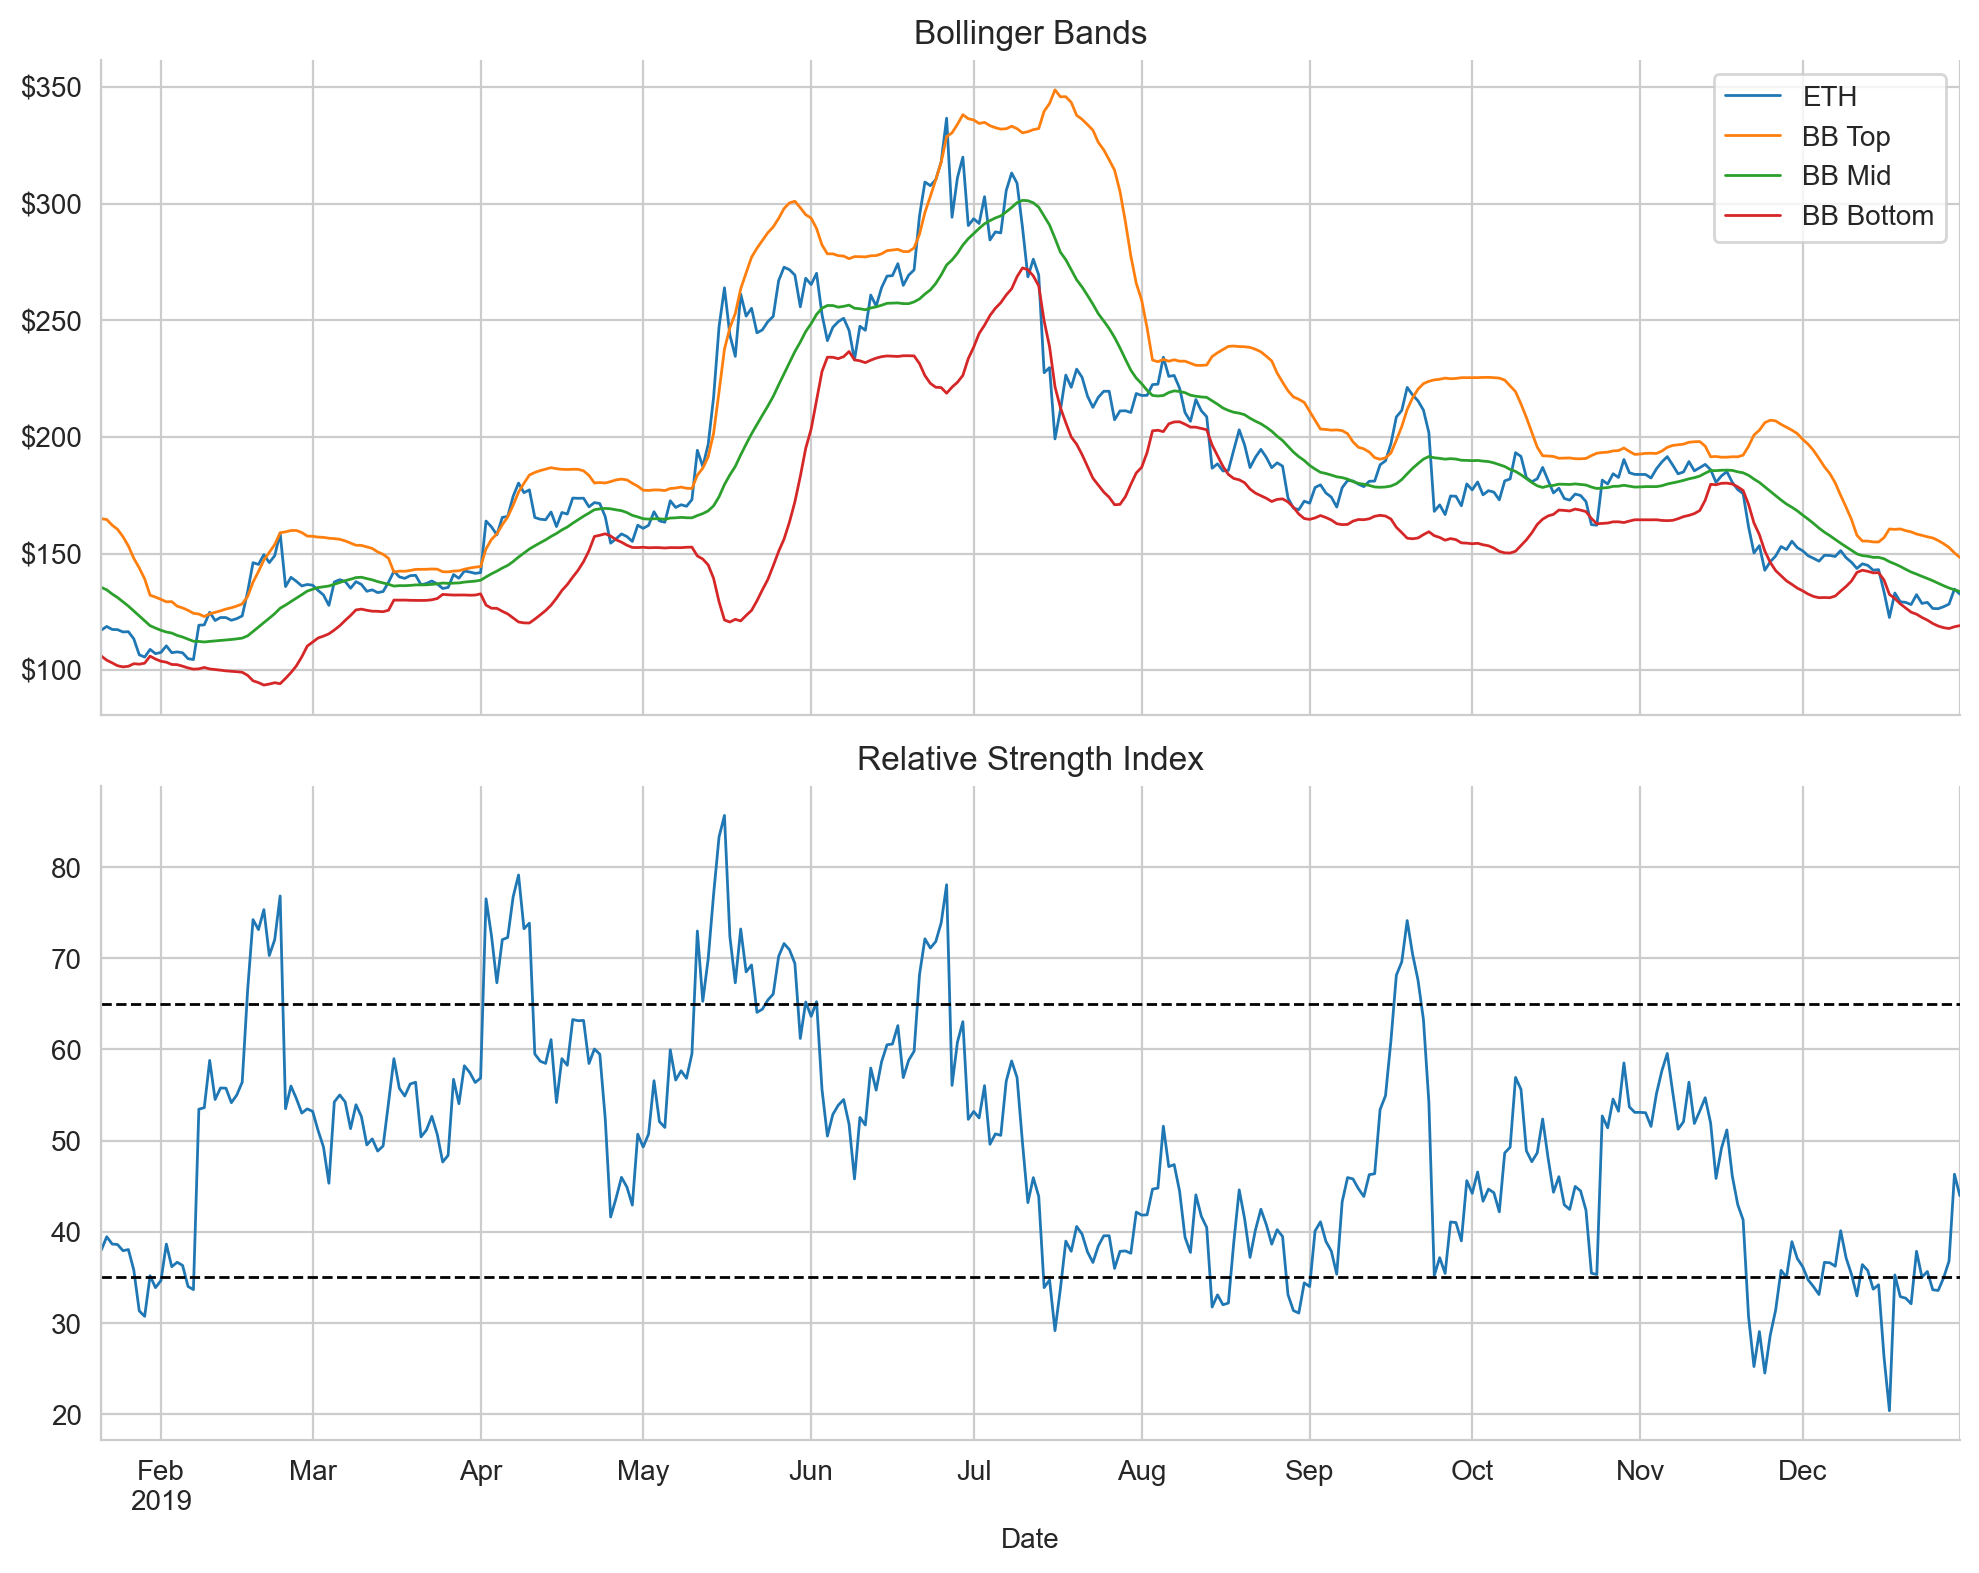

In [353]:
# plot    
fig, axes = plt.subplots(nrows=2, figsize=(10, 8), sharex=True)
dat.drop(['RSI'], axis=1).plot(ax=axes[0], lw=1, title='Bollinger Bands')
dat['RSI'].plot(ax=axes[1], lw=1, title='Relative Strength Index')
axes[0].yaxis.set_major_formatter(dollar_formatter)
axes[1].axhline(65, lw=1, ls='--', c='k')
axes[1].axhline(35, lw=1, ls='--', c='k')
fig.tight_layout()
sns.despine()
plt.savefig(os.path.join(png_dir, f'bb-rsi-{ticker}-{start}.png'), dpi=300)

## Trading Strategy

- Buy when price falls below 110% of BB bottom band and RSI falls below 35.
- Sell when price rises above 90% of BB top band and RSI rises above 65.
- No shorting, no leverage.

In [354]:
# create bb signals
signal_var = 'bb_signal'
dat[signal_var] = 'hold'
sell = dat[ticker] >= dat['BB Top']*0.9
buy = dat[ticker] <= dat['BB Bottom']*1.1
dat.loc[sell, signal_var] = 'sell'
dat.loc[buy, signal_var] = 'buy'
dat.head()

,ETH,BB Top,BB Mid,BB Bottom,RSI,bb_signal
Date,,,,,,
2019-01-21,117.1579,164.9463,135.4962,106.0462,38.0008,hold
2019-01-22,118.7476,164.6267,134.4452,104.2637,39.4625,hold
2019-01-23,117.4526,162.1889,132.6550,103.1210,38.6628,hold
2019-01-24,117.3629,160.3979,131.1420,101.8861,38.6045,hold
2019-01-25,116.3783,157.2429,129.3228,101.4027,37.9278,hold


In [355]:
# create RSI signals
signal_var = 'rsi_signal'
dat[signal_var] = 'hold'
buy = dat['RSI'] <= 35
sell = dat['RSI'] >= 65
dat.loc[buy, signal_var] = 'buy'
dat.loc[sell, signal_var] = 'sell'
dat.head()

,ETH,BB Top,BB Mid,BB Bottom,RSI,bb_signal,rsi_signal
Date,,,,,,,
2019-01-21,117.1579,164.9463,135.4962,106.0462,38.0008,hold,hold
2019-01-22,118.7476,164.6267,134.4452,104.2637,39.4625,hold,hold
2019-01-23,117.4526,162.1889,132.6550,103.1210,38.6628,hold,hold
2019-01-24,117.3629,160.3979,131.1420,101.8861,38.6045,hold,hold
2019-01-25,116.3783,157.2429,129.3228,101.4027,37.9278,hold,hold


In [356]:
# create trading signal based on the confluence of bb and rsi signals
# if they disagree, hold; otherwise go with their agreement
agree = dat['bb_signal'] == dat['rsi_signal']
dat.loc[agree, 'signal'] = dat.loc[agree, 'rsi_signal']
dat.loc[~agree, 'signal'] = 'hold'
dat.head()

,ETH,BB Top,BB Mid,BB Bottom,RSI,bb_signal,rsi_signal,signal
Date,,,,,,,,
2019-01-21,117.1579,164.9463,135.4962,106.0462,38.0008,hold,hold,hold
2019-01-22,118.7476,164.6267,134.4452,104.2637,39.4625,hold,hold,hold
2019-01-23,117.4526,162.1889,132.6550,103.1210,38.6628,hold,hold,hold
2019-01-24,117.3629,160.3979,131.1420,101.8861,38.6045,hold,hold,hold
2019-01-25,116.3783,157.2429,129.3228,101.4027,37.9278,hold,hold,hold


In [357]:
dat.groupby('signal')['signal'].count()

signal
buy      36
hold    265
sell     43
Name: signal, dtype: int64

In [358]:
def run_strat(dat, ticker, action_col, buy_amt_usd):
    """Backtest the strategy on historical data. """
    # cut the data so that they start with a buy signal to avoid shorting 
    start_idx = dat.loc[dat[action_col] == 'buy'].index[0]
    dat = dat.loc[start_idx:].copy()
    # day 1 is a buy
    day1 = dat.index[0]
    day1_price = dat.loc[day1, ticker]
    day1_trade = dat.loc[day1, action_col]
    day1_shares = buy_amt_usd / day1_price
    day1_cash = 0
    
    # day1 becomes yesterday when we move to day2    
    yesterday_trade = day1_trade
    yesterday_price = day1_price
    yesterday_shares = day1_shares
    yesterday_cash = day1_cash
    # iterate over all days and collect (cumulative) results 
    shares = [day1_shares]
    cashes = [day1_cash]
    values = [buy_amt_usd]
    for i in range(1, len(dat)):
        today = dat.index[i]
        today_price = dat.loc[today, ticker]
        today_trade = dat.loc[today, action_col]
        if today_trade == 'hold':
            today_shares = yesterday_shares
            today_cash = yesterday_cash
        elif today_trade == 'buy':
            today_shares = (yesterday_cash + buy_amt_usd) / today_price + yesterday_shares
            today_cash = 0
        elif today_trade == 'sell':
            today_cash = yesterday_shares * today_price + yesterday_cash
            today_shares = 0
        else:
            pass
        shares.append(today_shares)
        cashes.append(today_cash)
        values.append(today_shares * today_price + today_cash)
        # update
        yesterday_trade = today_trade
        yesterday_price = today_price
        yesterday_shares = today_shares
        yesterday_cash = today_cash
    # append to dat and return    
    dat.loc[:,'shares'] = shares
    dat.loc[:,'cash'] = cashes
    dat.loc[:,'strat_value'] = values
    return dat

In [359]:
bt_res = run_strat(dat, ticker, 'signal', buy_amount_usd)

In [360]:
bt_res.head(30)

,ETH,BB Top,BB Mid,BB Bottom,RSI,bb_signal,rsi_signal,signal,shares,cash,strat_value
Date,,,,,,,,,,,
2019-01-28,106.5900,143.8492,123.1990,102.5488,31.3307,buy,buy,buy,0.9382,0.0000,100.0000
2019-01-29,105.5982,139.1437,121.0675,102.9912,30.7311,buy,buy,buy,1.8852,0.0000,199.0696
2019-01-30,108.9075,132.1328,119.0724,106.0121,35.1878,buy,hold,hold,1.8852,0.0000,205.3082
2019-01-31,107.0610,131.3292,118.0456,104.7620,33.8781,buy,buy,buy,2.8192,0.0000,301.8272
2019-02-01,107.6098,130.3774,117.0961,103.8148,34.6565,buy,buy,buy,3.7485,0.0000,403.3743
2019-02-02,110.4303,129.3054,116.3563,103.4072,38.6539,buy,hold,hold,3.7485,0.0000,413.9468
2019-02-03,107.4927,129.3912,115.9084,102.4257,36.1719,buy,hold,hold,3.7485,0.0000,402.9353
2019-02-04,107.8216,127.4329,114.8967,102.3604,36.6623,buy,hold,hold,3.7485,0.0000,404.1683
2019-02-05,107.4435,126.6963,114.2019,101.7076,36.3169,buy,hold,hold,3.7485,0.0000,402.7510


In [361]:
bt_res.iloc[20:40]

,ETH,BB Top,BB Mid,BB Bottom,RSI,bb_signal,rsi_signal,signal,shares,cash,strat_value
Date,,,,,,,,,,,
2019-02-17,133.5989,131.6164,114.6994,97.7825,66.4842,sell,sell,sell,0.0000,755.9317,755.9317
2019-02-18,146.0984,137.7300,116.5808,95.4316,74.2353,sell,sell,sell,0.0000,755.9317,755.9317
2019-02-19,145.3462,142.2978,118.4736,94.6493,73.1391,sell,sell,sell,0.0000,755.9317,755.9317
2019-02-20,149.5543,147.2267,120.4091,93.5916,75.3336,sell,sell,sell,0.0000,755.9317,755.9317
2019-02-21,146.1308,150.5082,122.2696,94.0310,70.3017,sell,sell,sell,0.0000,755.9317,755.9317
2019-02-22,149.0925,153.8746,124.2449,94.6153,72.0415,sell,sell,sell,0.0000,755.9317,755.9317
2019-02-23,158.7954,158.9166,126.5481,94.1795,76.8305,sell,sell,sell,0.0000,755.9317,755.9317
2019-02-24,135.8527,159.3271,127.8985,96.4699,53.4967,hold,hold,hold,0.0000,755.9317,755.9317
2019-02-25,139.8229,159.8982,129.4224,98.9466,55.9877,hold,hold,hold,0.0000,755.9317,755.9317


In [362]:
# calc the value of buyhold strategy
capital = (bt_res['signal'] == 'buy').sum() * buy_amount_usd
day1_price = bt_res[ticker][0]
shares = capital / day1_price
bt_res['buyhold_value'] = bt_res[ticker] * shares
bt_res[[ticker, 'signal', 'strat_value', 'buyhold_value']].head()

,ETH,signal,strat_value,buyhold_value
Date,,,,
2019-01-28,106.5900,buy,100.0000,"3,600.0000"
2019-01-29,105.5982,buy,199.0696,"3,566.5040"
2019-01-30,108.9075,hold,205.3082,"3,678.2741"
2019-01-31,107.0610,buy,301.8272,"3,615.9090"
2019-02-01,107.6098,buy,403.3743,"3,634.4435"


In [363]:
# calculate APY of our strategy and buyhold 
end_value = bt_res[['strat_value', 'buyhold_value']].iloc[-1]
roi = (end_value - capital) / capital
dur_days = len(bt_res)
daily_ret = (roi+1) ** (1/dur_days)-1
APY = ((1+daily_ret)**365-1)
APY.name = 'APY'
APY = APY.to_frame()
APY.index = ['my_strat', 'buyhold_'+ticker]
APY

,APY
my_strat,-0.0626
buyhold_ETH,0.2671


In [364]:
strat_apy = '{:.2%} APY'.format(APY.loc['my_strat'][0])
buyhold_apy = '{:.2%} APY'.format(APY.loc['buyhold_'+ticker][0])

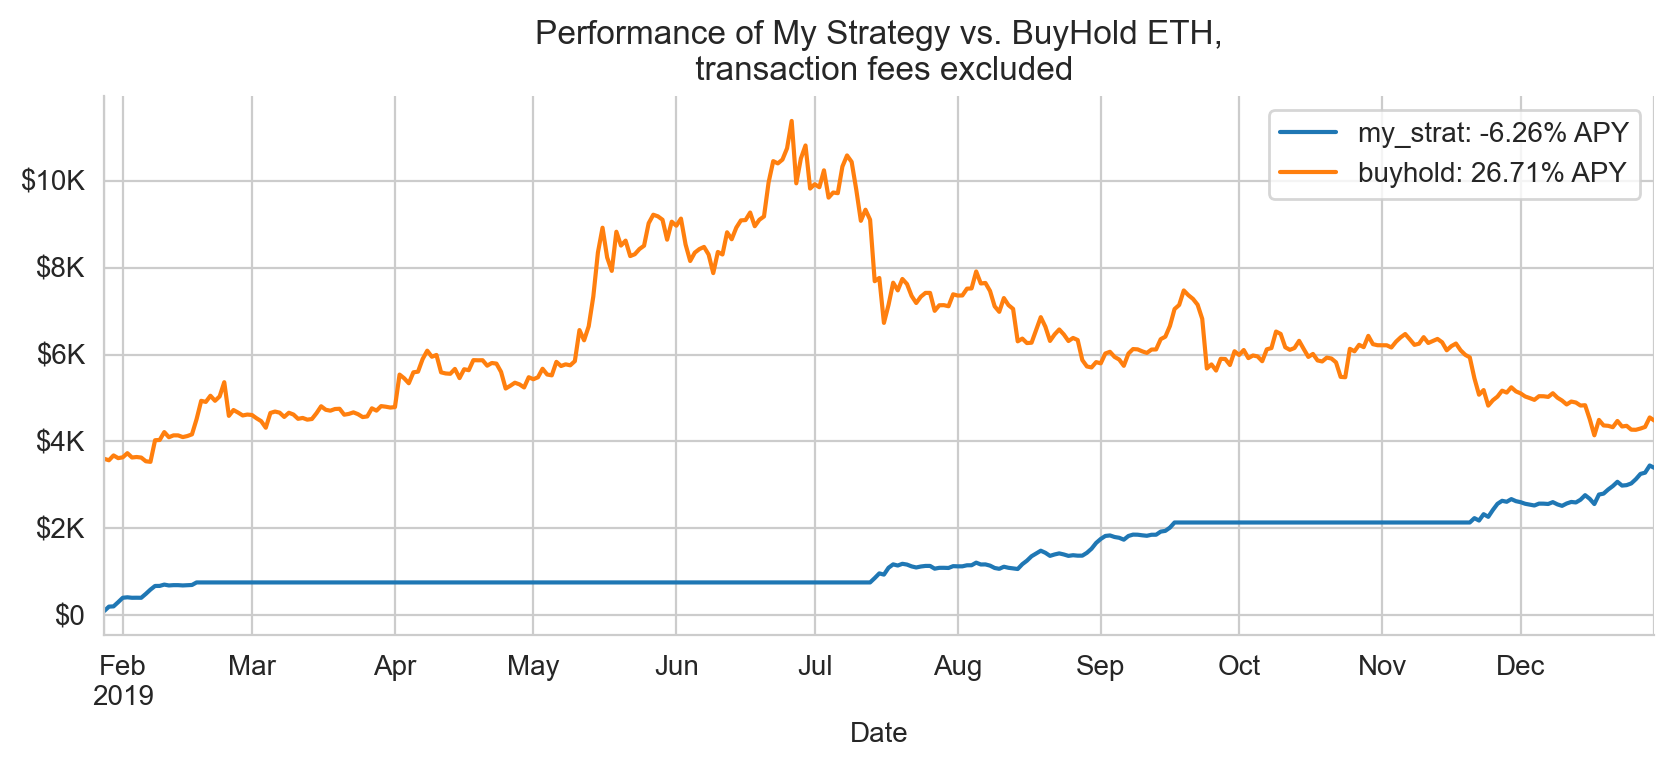

In [365]:
ax = bt_res[['strat_value', 'buyhold_value']]\
    .rename(columns={'strat_value':'my_strat: '+strat_apy,
                     'buyhold_value':'buyhold: '+buyhold_apy})\
    .plot(title=f'Performance of My Strategy vs. BuyHold {ticker},\n transaction fees excluded')
ax.yaxis.set_major_formatter(dollar_formatter)
fig.tight_layout()
sns.despine()
plt.savefig(os.path.join(png_dir, f'backtest-bb-rsi-{ticker}-{start}.png'), dpi=300)